In [1]:
# 한 도시시의 키오스크로 대여한 자전거 기록들을 train데이터와 test데이터를 활용해 예측하는 분석
# test데이터에는 'casual, registered, count'데이터가 존재하지 않는다.
# eda(탐색적 데이터 분석)를 실시
# 분류와 회귀중 회귀와 관련 된 문제
# 지도학습과 비지도학습 중 레이블(train데이터에 count)이 존재하기 때문

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 하는 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트가 깨지는 문제에 해결을 위한 방법
mpl.rcParams['axes.unicode_minus'] = False

# 경고메시지 숨기기 (다시 출력하려면 ignore를 default로 수정)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 폰트바뀌었는지 확인
print (plt.rcParams['font.family'] )

['NanumGothic']


In [3]:
# parse_dates = ['datetime']를 하면 datetime 칼럼이 시간으로 분류되 전처리가 쉬워진다.
train = pd.read_csv('C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/train.csv', parse_dates = ['datetime'])
train.shape

(10886, 12)

In [4]:
# train.columns 칼럼만 출력
# train.dtypes 칼럼의 데이터 타입 출력
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## 많은 칼럼 중 기온만 기술통계량 출력

In [5]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

## 결측값 확인

In [6]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## 결측값 시각화

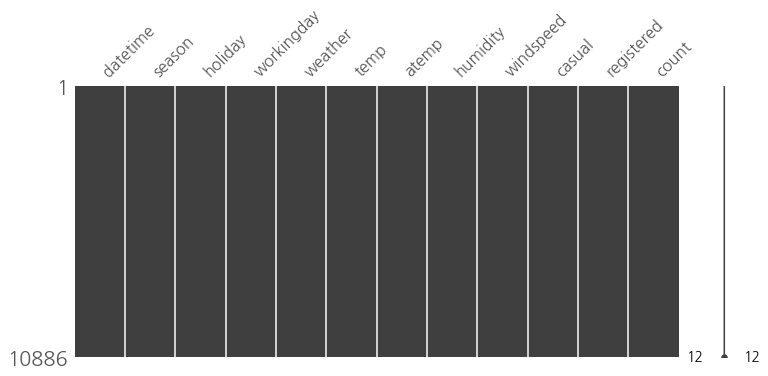

In [7]:
import missingno as msno

msno.matrix(train, figsize = (12, 5))

## datetime을 나누어 파생변수 생성하는 전처리

In [8]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

display(train.shape)
display(train.head())

(10886, 18)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

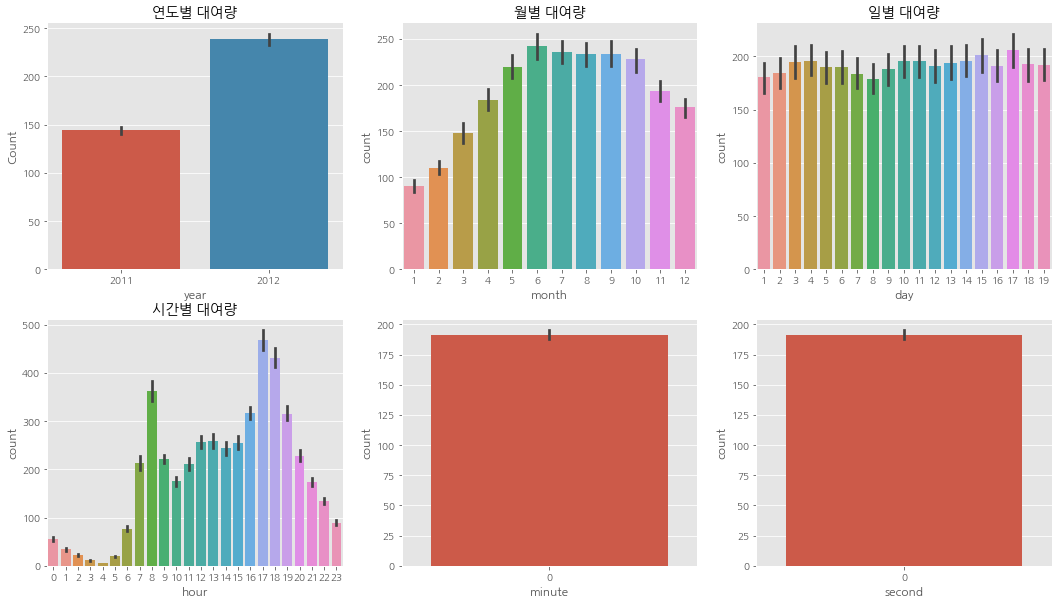

In [9]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(18,10)

sns.barplot(data = train, x = "year", y = "count", ax = ax1)
sns.barplot(data = train, x = "month", y = "count", ax = ax2)
sns.barplot(data = train, x = "day", y = "count", ax = ax3)
sns.barplot(data = train, x = "hour", y = "count", ax = ax4)
sns.barplot(data = train, x = "minute", y = "count", ax = ax5)
sns.barplot(data = train, x = "second", y = "count", ax = ax6)

ax1.set(ylabel = 'Count', title = "연도별 대여량")
ax2.set(xlabel = 'month', title = "월별 대여량")
ax3.set(xlabel = 'day', title = "일별 대여량")
ax4.set(xlabel = 'hour', title = "시간별 대여량")

 * 일별 대여량은 1일부터 19일까지만 존재하고 나머지는 test.csv에 존재해 사용할 수 없다.
 * 시간별 대여량은 출퇴근 시간에 집중된거 같으나, 평일과 주말의 차이가 존재할 수 있으므로 나누어 봐야 한다.
 * 분과 초의 데이터는 전부 '0'이기 때문에 의미가 없다.


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, '평일과 주말의 대여량')]

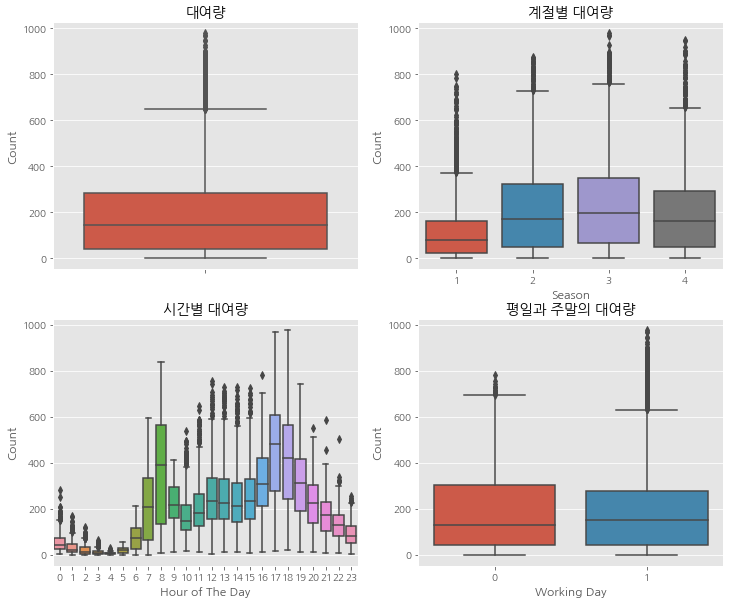

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12, 10)
sns.boxplot(data = train, y = "count", orient = "v", ax = axes[0][0])
sns.boxplot(data = train, y= "count", x = "season", orient = "v", ax = axes[0][1])
sns.boxplot(data = train, y= "count", x = "hour", orient = "v", ax = axes[1][0])
sns.boxplot(data = train, y= "count", x = "workingday", orient = "v", ax = axes[1][1])

axes[0][0].set(ylabel = 'Count', title = "대여량")
axes[0][1].set(xlabel = 'Season', ylabel = 'Count', title = "계절별 대여량")
axes[1][0].set(xlabel = 'Hour of The Day', ylabel = 'Count', title = "시간별 대여량")
axes[1][1].set(xlabel = 'Working Day', ylabel = 'Count', title = "평일과 주말의 대여량")

In [11]:
# dayofweek 데이터가 빠져있으므로 불러오는 작업
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [12]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

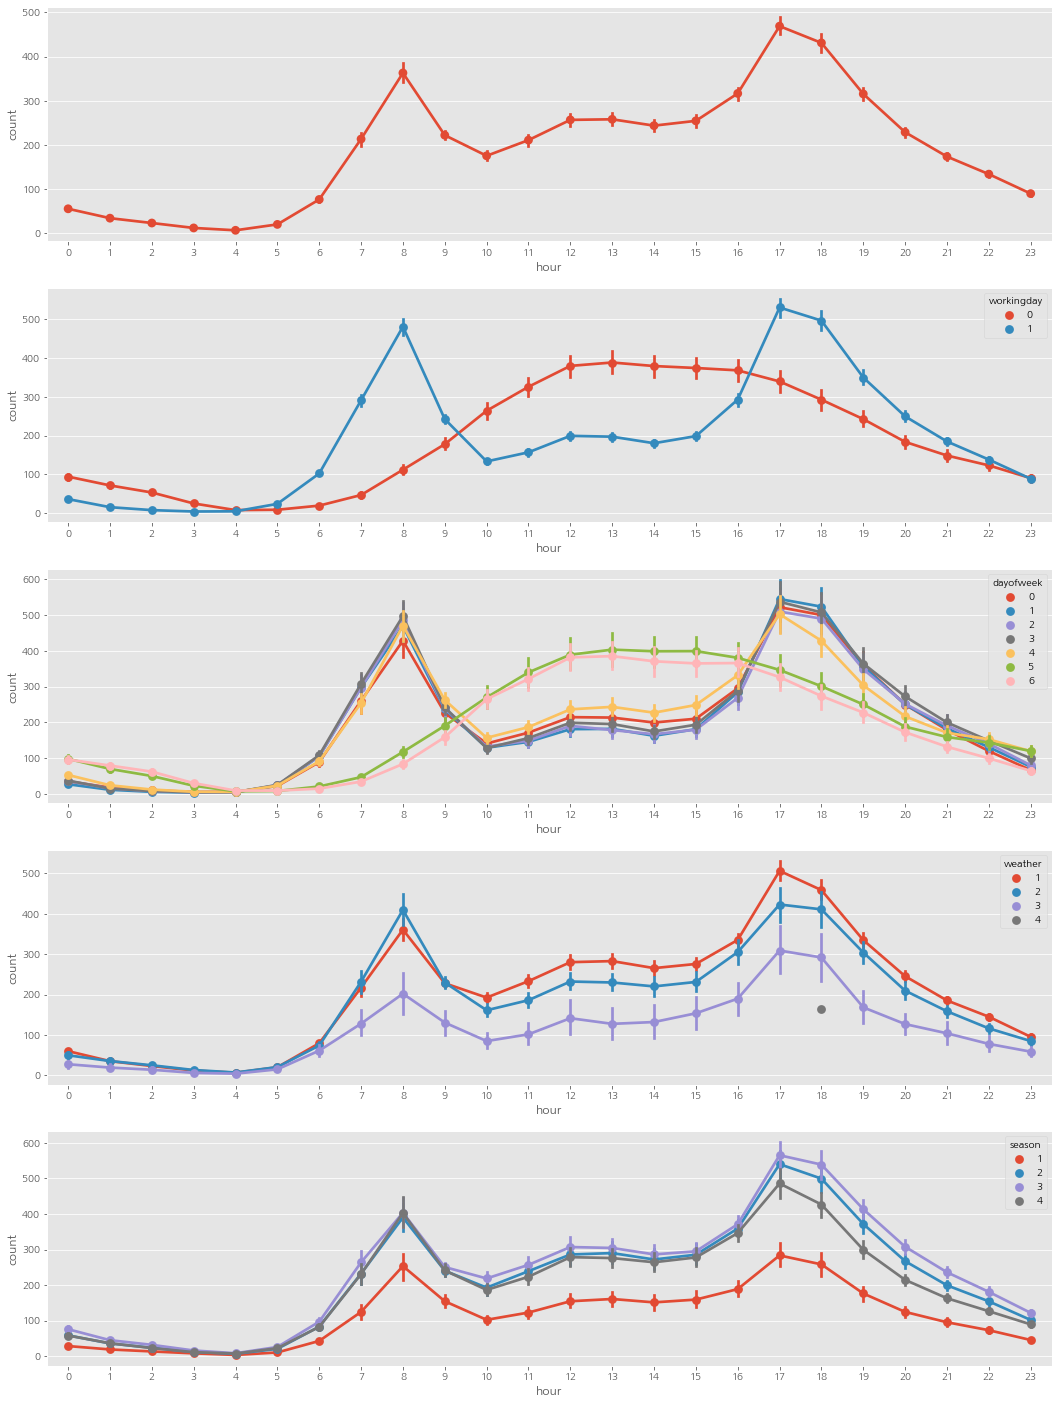

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
fig.set_size_inches(18,25)

sns.pointplot(data = train, x = "hour", y = "count", ax = ax1)

sns.pointplot(data = train, x = "hour", y = "count", hue = "workingday", ax = ax2)

sns.pointplot(data = train, x = "hour", y = "count", hue = "dayofweek", ax = ax3)

sns.pointplot(data = train, x = "hour", y = "count", hue = "weather", ax = ax4)

sns.pointplot(data = train, x = "hour", y = "count", hue = "season", ax = ax5)

In [14]:
# 상관계수행렬 출력
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

print(corrMatt)

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


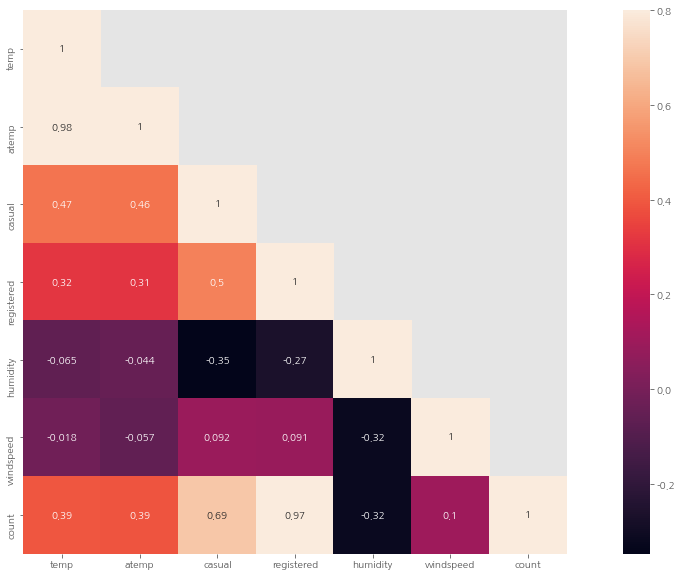

In [15]:
# 상관계수 행렬을 히트맵으로 표현
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask = mask, vmax = .8, square = True, annot = True)    # mask = mask는 주대각선 위 행렬을 삭제해 출력 시켜 보여준다

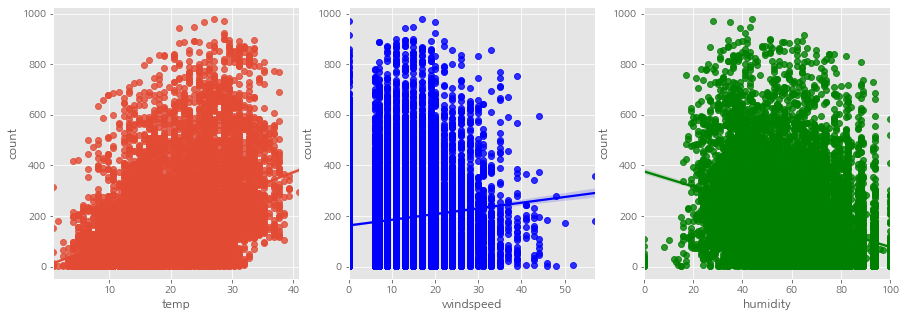

In [16]:
fig,(ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(15, 5)
sns.regplot(x = "temp", y = "count", data = train, ax = ax1)
sns.regplot(x = "windspeed", y = "count", data = train, ax = ax2, color = 'blue')
sns.regplot(x = "humidity", y = "count", data = train, ax = ax3, color = 'green')

 * 풍속데이터에 0이라고 측정된 이유는 결측값으로 지정한 이유로 보인다.

In [17]:
# 2011년 데이터와 2012년 데이터를 붙여 월별로 합친다.
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


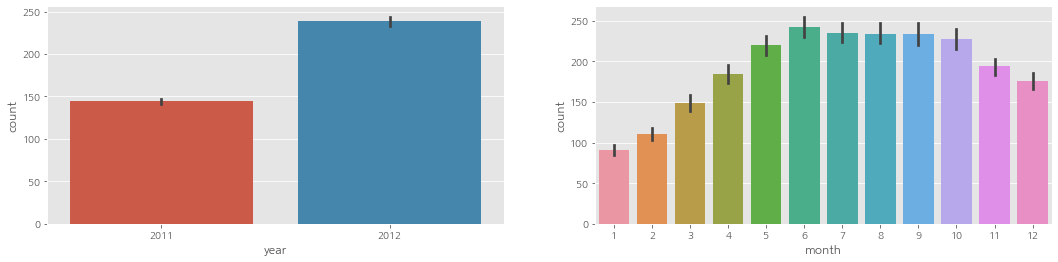

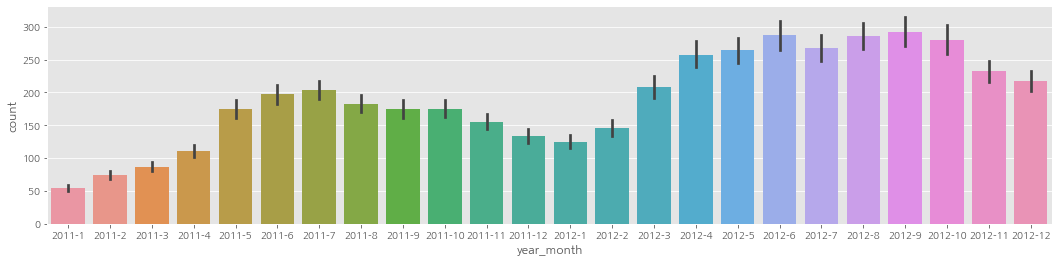

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(18, 4)

sns.barplot(data = train, x = "year", y = "count", ax = ax1)
sns.barplot(data = train, x = "month", y = "count", ax = ax2)

fig, ax3 = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(18, 4)

sns.barplot(data = train, x = "year_month", y = "count", ax = ax3)

 ## 이상치 제거

In [27]:
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

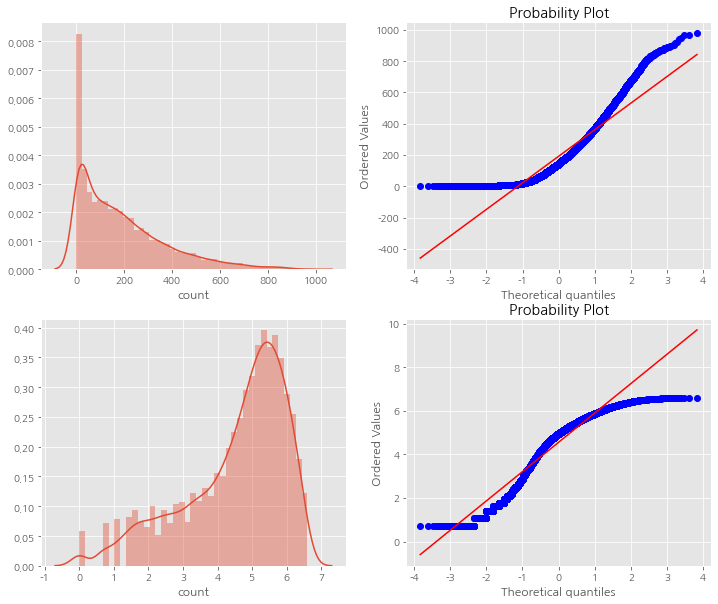

In [33]:
# 이상치 제거 후 count값의 데이터 분포도 확인
figure, axes = plt.subplots(ncols = 2, nrows = 2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax = axes[0][0])
stats.probplot(train["count"], dist = 'norm', fit = True, plot = axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax = axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist = 'norm', fit = True, plot = axes[1][1])

 * 위 두 그래프는 이상치로 잡힌 '0'과 3분위수가 넘는 데이터를 삭제해 전처리하고 전 후를 살펴보는 그래프이다.
 * 이상치를 제거하고 났을 때 완전한 정규분포를 따른다고 보기는 힘들지만, 어느정도 정규성은 따른다고 볼 수 있다.

 # sklearn
 * 사이킷런은 분류(classification), 회귀, clusterring, 차원축소(dimensionality reduction)에 사용된다.
 * 분류는 일반적으로 타이타닉에서 사용하는 예제가 존재한다.
 * 자전거 데이터는 회귀 중 랜덤포레스트 방법을 적용해 본다.
 * k-fold 교차검증을 통해 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해 나누고 여러 모델을 학습한다.

In [34]:
# 모델평가 공식
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    
    # 넘파이로 배열 형태로 전환
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 르그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 더해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    retturn